# Import Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import random

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from string import punctuation
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             accuracy_score, confusion_matrix, roc_auc_score,
                             roc_curve, auc)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM

In [ ]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Initialize lemmatizer
lemma = WordNetLemmatizer()

# Loading Dataset

In [ ]:
# Unzip dataset
!unzip dataset_CellPhoneAmazon.zip

Archive:  dataset_CellPhoneAmazon.zip
  inflating: Cell_Phones_and_Accessories_5 - Copy.json  


In [ ]:
# Load dataset
df = pd.read_json('Cell_Phones_and_Accessories_5 - Copy.json', lines=True)

In [ ]:
df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [ ]:
# Drop unnecessary columns
df.drop(['reviewerID', 'asin', 'reviewerName', 'helpful', 'summary',
         'unixReviewTime', 'reviewTime'], axis='columns', inplace=True)

In [ ]:
# Rename columns
df = df.rename(columns={"reviewText": "Review", "overall": "Rating"})

In [ ]:
# Add review length column
df['review_len'] = df['Review'].apply(lambda x: len(x.split()))

In [ ]:
# Filter reviews based on length
df = df[(df['review_len'] >= 20) & (df['review_len'] <= 40)]

In [ ]:
# Convert rating to binary sentiment
def convert_label(rating):
    return 0 if rating <= 3.0 else 1

df['Rating'] = df['Rating'].apply(convert_label)


In [ ]:
df.head()

,Review,Rating,review_len
0,Ive been looking everywhere for affordable nfc...,1,21
7,"Chose this glow in the dark,because my daughte...",1,22
19,"Phone works great, a lot of battery time. Full...",1,25
52,I love jawbone Bluetooth headsets. They are cr...,1,28
64,Jawbone rocks! This bluetooth allows me to lis...,1,36


# EDA

In [ ]:
# Most common words function
def MostWordsUsed(txt, n_words):
    all_text = ''.join(df[txt].values)
    all_text = re.sub(r'\d+', '', all_text)  # Remove numbers
    all_text = re.sub(r'[^\w\s]', '', all_text)  # Remove special characters

    words = all_text.split()
    stop_words = set(stopwords.words('english'))
    words = [word.lower() for word in words if word.lower() not in stop_words and word not in punctuation]

    word_counts = Counter(words)
    return word_counts.most_common(n_words)

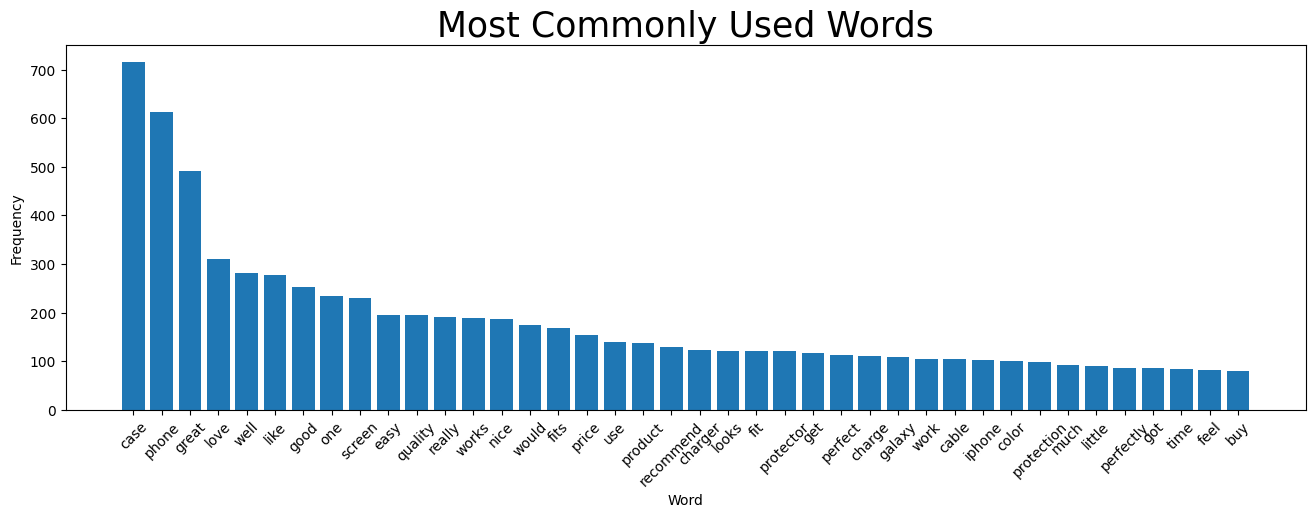

In [ ]:
# Plot most common words
top_words = MostWordsUsed('Review', 40)
xaxis = [word[0] for word in top_words]
yaxis = [word[1] for word in top_words]

plt.figure(figsize=(16, 5))
plt.bar(xaxis, yaxis)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words', fontsize=25)
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.15)
plt.show()

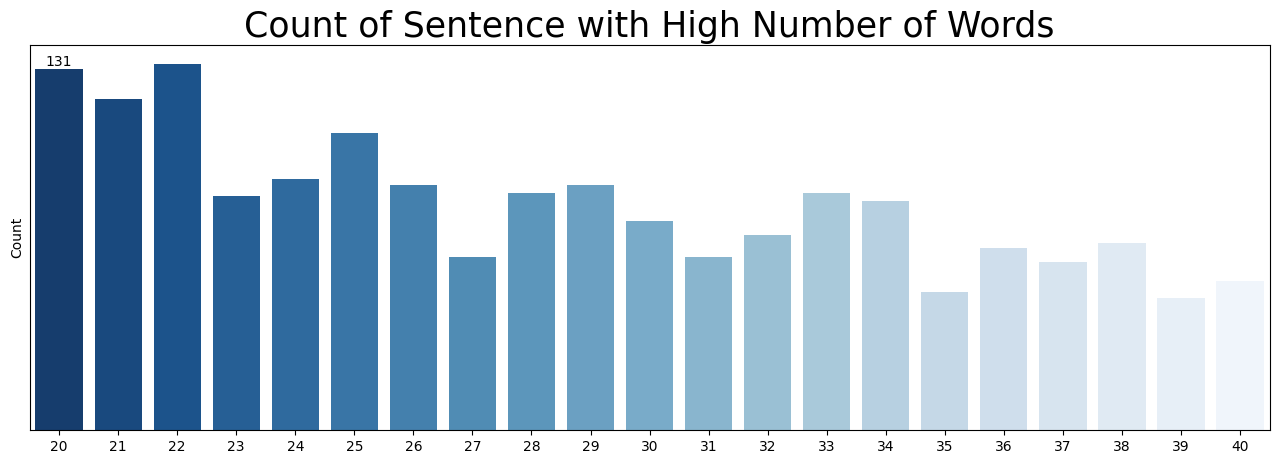

In [ ]:
# Plot review length distribution
plt.figure(figsize=(16, 5))
ax = sns.countplot(x='review_len', data=df[(df['review_len'] <= 1000) & (df['review_len'] > 10)], palette='Blues_r')
plt.title('Count of Sentence with High Number of Words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Count')
plt.xlabel('')
plt.show()

# Data Preprocessing

In [ ]:
# Data preparation function
def DataPrep(text):
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters

    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [lemma.lemmatize(word.lower()) for word in tokens if word.lower() not in stop_words and word not in punctuation]

    return ' '.join(words)

In [ ]:
# Clean reviews
df['cleaned_reviews'] = df['Review'].apply(DataPrep)

# Remove duplicated reviews
df.drop_duplicates('cleaned_reviews', inplace=True)


# Split the data

In [ ]:
# Split data
x_train, x_val, y_train, y_val = train_test_split(df['cleaned_reviews'], df['Rating'], train_size=0.80, random_state=42)


In [ ]:
len(x_train) , len(x_val)

(1373, 344)

# Feature Extraction

In [ ]:
# Vectorize text data
vec = TfidfVectorizer(max_features=5000)
vec.fit(x_train)

TfidfVectorizer(max_features=5000)

In [ ]:
x_train = vec.transform(x_train).toarray()
x_val = vec.transform(x_val).toarray()


In [ ]:
x_train.shape , x_val.shape

((1373, 2838), (344, 2838))

# Logistic Regression

In [ ]:
# Logistic Regression
lr = LogisticRegression(random_state=42)
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_val)

The training accuracy for Logistic Regression: 86.96%
The validation accuracy for Logistic Regression: 89.53%
The precision for Logistic Regression: 0.91
The recall for Logistic Regression: 0.90
The F1 score for Logistic Regression: 0.85


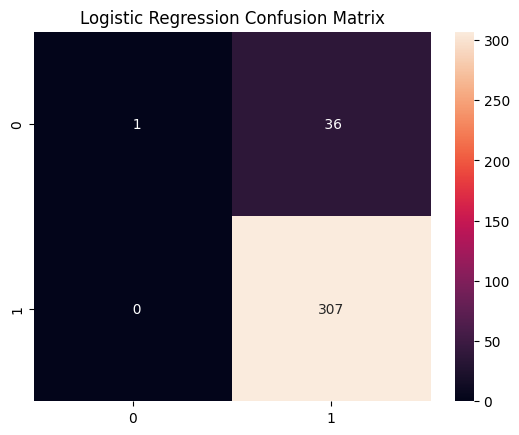

In [ ]:
train_acc1 = lr.score(x_train, y_train)
val_acc1 = accuracy_score(y_val, lr_pred)
val_precision1 = precision_score(y_val, lr_pred, average='weighted')
val_recall1 = recall_score(y_val, lr_pred, average='weighted')
val_f1score1 = f1_score(y_val, lr_pred, average='weighted')
lr_cm = confusion_matrix(y_val, lr_pred)

print(f"The training accuracy for Logistic Regression: {(train_acc1*100):0.2f}%")
print(f"The validation accuracy for Logistic Regression: {(val_acc1*100):0.2f}%")
print(f"The precision for Logistic Regression: {val_precision1:0.2f}")
print(f"The recall for Logistic Regression: {val_recall1:0.2f}")
print(f"The F1 score for Logistic Regression: {val_f1score1:0.2f}")

sns.heatmap(lr_cm, annot=True, fmt='3g')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

#SVM

In [ ]:
# Support Vector Machine
svm = SVC(kernel='linear', probability=True)
svm.fit(x_train, y_train)
svm_pred = svm.predict(x_val)

The training accuracy for SVM: 95.63%
The validation accuracy for SVM: 90.99%
The precision for SVM: 0.90
The recall for SVM: 0.91
The F1 score for SVM: 0.89


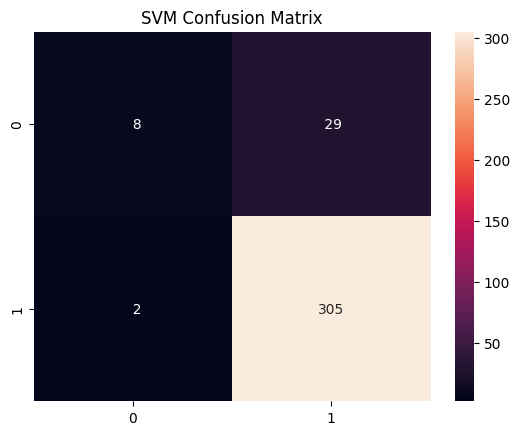

In [ ]:
train_acc4 = svm.score(x_train, y_train)
val_acc4 = accuracy_score(y_val, svm_pred)
val_precision4 = precision_score(y_val, svm_pred, average='weighted')
val_recall4 = recall_score(y_val, svm_pred, average='weighted')
val_f1score4 = f1_score(y_val, svm_pred, average='weighted')
svm_cm = confusion_matrix(y_val, svm_pred)

print(f"The training accuracy for SVM: {(train_acc4*100):0.2f}%")
print(f"The validation accuracy for SVM: {(val_acc4*100):0.2f}%")
print(f"The precision for SVM: {val_precision4:0.2f}")
print(f"The recall for SVM: {val_recall4:0.2f}")
print(f"The F1 score for SVM: {val_f1score4:0.2f}")

sns.heatmap(svm_cm, annot=True, fmt='3g')
plt.title('SVM Confusion Matrix')
plt.show()

#Naive Byes

In [ ]:
# Naive Bayes
nb = MultinomialNB()
nb.fit(x_train, y_train)
nb_pred = nb.predict(x_val)

The training accuracy for Naive Bayes: 86.31%
The validation accuracy for Naive Bayes: 89.24%
The precision for Naive Bayes: 0.80
The recall for Naive Bayes: 0.89
The F1 score for Naive Bayes: 0.84


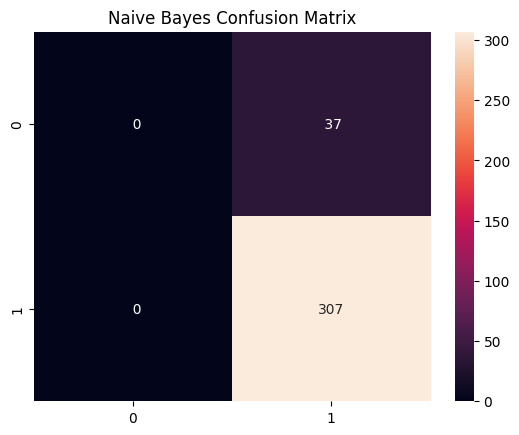

In [ ]:
train_acc5 = nb.score(x_train, y_train)
val_acc5 = accuracy_score(y_val, nb_pred)
val_precision5 = precision_score(y_val, nb_pred, average='weighted')
val_recall5 = recall_score(y_val, nb_pred, average='weighted')
val_f1score5 = f1_score(y_val, nb_pred, average='weighted')
nb_cm = confusion_matrix(y_val, nb_pred)

print(f"The training accuracy for Naive Bayes: {(train_acc5*100):0.2f}%")
print(f"The validation accuracy for Naive Bayes: {(val_acc5*100):0.2f}%")
print(f"The precision for Naive Bayes: {val_precision5:0.2f}")
print(f"The recall for Naive Bayes: {val_recall5:0.2f}")
print(f"The F1 score for Naive Bayes: {val_f1score5:0.2f}")

sns.heatmap(nb_cm, annot=True, fmt='3g')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

# Random Forest Classifier

In [ ]:
# Random Forest
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_val)

The training accuracy for Random Forest: 100.00%
The validation accuracy for Random Forest: 89.83%
The precision for Random Forest: 0.88
The recall for Random Forest: 0.90
The F1 score for Random Forest: 0.86


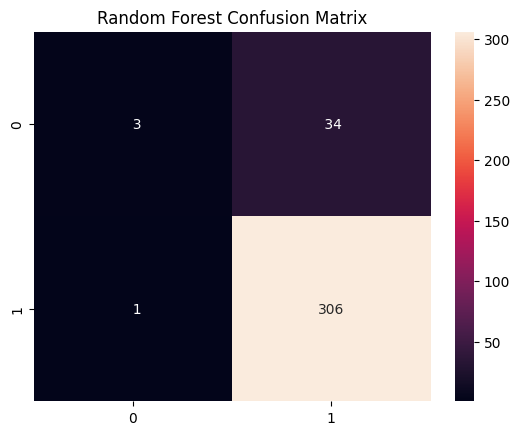

In [ ]:
train_acc2 = rf.score(x_train, y_train)
val_acc2 = accuracy_score(y_val, rf_pred)
val_precision2 = precision_score(y_val, rf_pred, average='weighted')
val_recall2 = recall_score(y_val, rf_pred, average='weighted')
val_f1score2 = f1_score(y_val, rf_pred, average='weighted')
rf_cm = confusion_matrix(y_val, rf_pred)

print(f"The training accuracy for Random Forest: {(train_acc2*100):0.2f}%")
print(f"The validation accuracy for Random Forest: {(val_acc2*100):0.2f}%")
print(f"The precision for Random Forest: {val_precision2:0.2f}")
print(f"The recall for Random Forest: {val_recall2:0.2f}")
print(f"The F1 score for Random Forest: {val_f1score2:0.2f}")

sns.heatmap(rf_cm, annot=True, fmt='3g')
plt.title('Random Forest Confusion Matrix')
plt.show()

#GBC

In [ ]:
# Gradient Boosting
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(x_train, y_train)
gbc_pred = gbc.predict(x_val)

The training accuracy for Gradient Boosting: 91.70%
The validation accuracy for Gradient Boosting: 90.99%
The precision for Gradient Boosting: 0.91
The recall for Gradient Boosting: 0.91
The F1 score for Gradient Boosting: 0.88


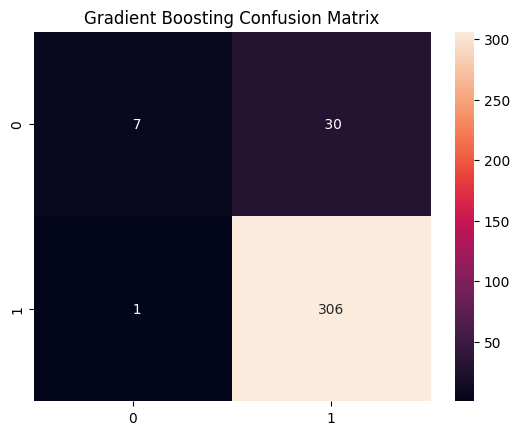

In [ ]:
train_acc3 = gbc.score(x_train, y_train)
val_acc3 = accuracy_score(y_val, gbc_pred)
val_precision3 = precision_score(y_val, gbc_pred, average='weighted')
val_recall3 = recall_score(y_val, gbc_pred, average='weighted')
val_f1score3 = f1_score(y_val, gbc_pred, average='weighted')
gbc_cm = confusion_matrix(y_val, gbc_pred)

print(f"The training accuracy for Gradient Boosting: {(train_acc3*100):0.2f}%")
print(f"The validation accuracy for Gradient Boosting: {(val_acc3*100):0.2f}%")
print(f"The precision for Gradient Boosting: {val_precision3:0.2f}")
print(f"The recall for Gradient Boosting: {val_recall3:0.2f}")
print(f"The F1 score for Gradient Boosting: {val_f1score3:0.2f}")

sns.heatmap(gbc_cm, annot=True, fmt='3g')
plt.title('Gradient Boosting Confusion Matrix')
plt.show()

# Compare between models

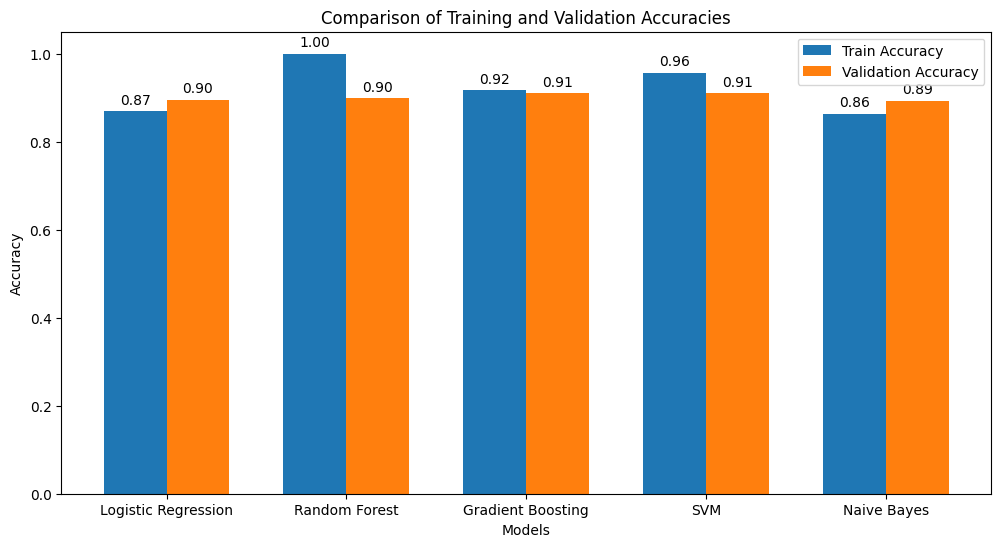

In [ ]:
# Updating train and validation scores
train_scores = [train_acc1, train_acc2, train_acc3, train_acc4, train_acc5]
val_scores = [val_acc1, val_acc2, val_acc3, val_acc4, val_acc5]

# Updating model names
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'SVM', 'Naive Bayes']

# Plot comparison
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Train Accuracy')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation Accuracy')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Training and Validation Accuracies')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC Curve and AUC for Logistic Regression
lr_fpr, lr_tpr, _ = roc_curve(y_val, lr.predict_proba(x_val)[:, 1])
lr_roc_auc = auc(lr_fpr, lr_tpr)

# Calculate ROC Curve and AUC for SVM
svm_fpr, svm_tpr, _ = roc_curve(y_val, svm.predict_proba(x_val)[:, 1])
svm_roc_auc = auc(svm_fpr, svm_tpr)

# Calculate ROC Curve and AUC for Naive Bayes
nb_fpr, nb_tpr, _ = roc_curve(y_val, nb.predict_proba(x_val)[:, 1])
nb_roc_auc = auc(nb_fpr, nb_tpr)

# Calculate ROC Curve and AUC for Random Forest
rf_fpr, rf_tpr, _ = roc_curve(y_val, rf.predict_proba(x_val)[:, 1])
rf_roc_auc = auc(rf_fpr, rf_tpr)

# Calculate ROC Curve and AUC for Gradient Boosting Classifier
gbc_fpr, gbc_tpr, _ = roc_curve(y_val, gbc.predict_proba(x_val)[:, 1])
gbc_roc_auc = auc(gbc_fpr, gbc_tpr)


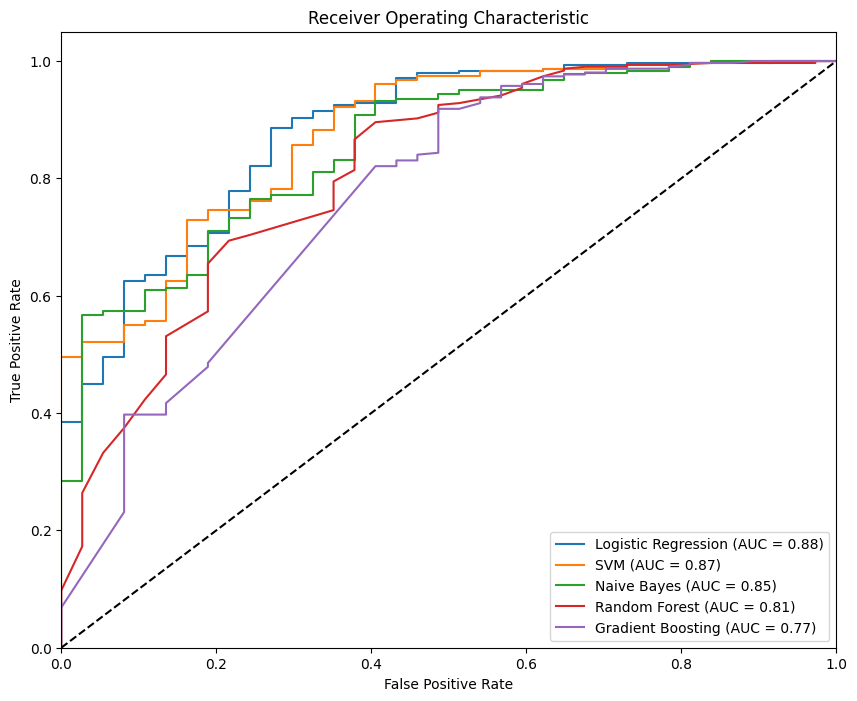

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Plot ROC curve for each model
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_roc_auc:0.2f})')
plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_roc_auc:0.2f})')
plt.plot(nb_fpr, nb_tpr, label=f'Naive Bayes (AUC = {nb_roc_auc:0.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_roc_auc:0.2f})')
plt.plot(gbc_fpr, gbc_tpr, label=f'Gradient Boosting (AUC = {gbc_roc_auc:0.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
